# <center> Train TrOCR on Deseret Dataset </center>

## Preprocessing

### Load the model

In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

checkpoint = "microsoft/trocr-base-printed"
processor = TrOCRProcessor.from_pretrained(checkpoint)
model = VisionEncoderDecoderModel.from_pretrained(checkpoint)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

### Prepare the data

In [2]:
from datasets import load_dataset

deseret_data = load_dataset("cayjobla/iam-deseret", split="train")

In [3]:
# Split the dataset
deseret_data = deseret_data.train_test_split(test_size=0.2)
deseret_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'english', 'deseret'],
        num_rows: 9075
    })
    test: Dataset({
        features: ['image', 'label', 'english', 'deseret'],
        num_rows: 2269
    })
})

because their pots would not stand fire ;
𐐺𐐮𐐿𐐫𐑆 𐑄𐐯𐑉 𐐹𐐪𐐻𐑅 𐐶𐐳𐐼 𐑌𐐪𐐻 𐑅𐐻𐐰𐑌𐐼 𐑁𐐴𐐲𐑉 ;


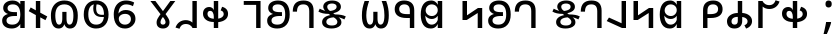

In [4]:
# Look at an example from the dataset
index = 128
print(deseret_data["train"][index]["english"])
print(deseret_data["train"][index]["deseret"])
display(deseret_data["train"][index]["image"])

In [ ]:
import torch

def preprocess(batch):       # TODO: Maybe make a class of this? (could hold max_length param, processor, etc.)
    pixel_values = processor(batch["image"], return_tensors="pt").pixel_values
    labels = processor.tokenizer(batch["english"], padding="max_length", return_tensors="pt").input_ids
    labels[labels == processor.tokenizer.pad_token_id] = -100
    return {"pixel_values": pixel_values.squeeze(), "labels": labels}

preprocessed_data = deseret_data.map(preprocess, batched=True, batch_size=8, remove_columns=["label"])
preprocessed_data.set_format("torch")

Map:   0%|          | 0/9075 [00:00<?, ? examples/s]

In [ ]:
preprocessed_data

DatasetDict({
    train: Dataset({
        features: ['image', 'english', 'deseret', 'pixel_values', 'labels'],
        num_rows: 9075
    })
    test: Dataset({
        features: ['image', 'english', 'deseret', 'pixel_values', 'labels'],
        num_rows: 2269
    })
})

system of recording temperatures .


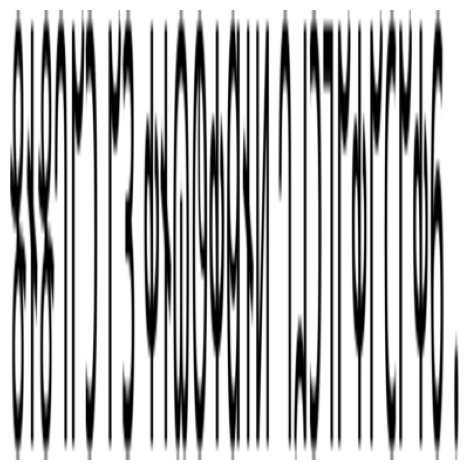

In [ ]:
import torchshow

example = preprocessed_data["train"][index]
pixel_values, labels = example["pixel_values"], example["labels"]
labels[labels == -100] = processor.tokenizer.pad_token_id
print(processor.decode(labels, skip_special_tokens=True))
torchshow.show(pixel_values)

## Prep for training

In [ ]:
# Set special tokens
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# Set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
train_dataset = preprocessed_data["train"].train_test_split(test_size=800)["train"]
test_dataset = preprocessed_data["test"].train_test_split(test_size=80)["test"]

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, 
    output_dir="./",
    logging_steps=1,
    save_steps=500,
    eval_steps=500,
)

/home/yungdankblast/anaconda3/envs/ocr_translator/lib/python3.13/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
import evaluate

cer_metric = evaluate.load("cer")

In [24]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
from transformers import default_data_collator

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,
    data_collator=default_data_collator,
)

/home/yungdankblast/anaconda3/envs/ocr_translator/lib/python3.13/site-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/tmp/ipykernel_1069/1964523123.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


## Train

In [ ]:
trainer.train()